In [9]:
import pandas as pd 

X_train = pd.read_csv("../../datasets/merged/X_train_imputed_scaled.csv", index_col=0)
X_test = pd.read_csv("../../datasets/merged/X_test_imputed_scaled.csv",  index_col=0)
y_train = pd.read_csv("../../datasets/merged/y_train.csv", index_col=0)["label"]
y_test = pd.read_csv("../../datasets/merged/y_test.csv",  index_col=0)["label"]
groups = pd.read_csv("../../datasets/merged/groups.csv", index_col=0)["star_key"]

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_metrics_vs_threshold(y_true, y_proba, title="Metrics vs Threshold"):
    thresholds = np.linspace(0.0, 1.0, 501)
    accs, precs, recs, f1s = [], [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        accs.append(accuracy_score(y_true, y_pred))
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, accs, label="Accuracy")
    plt.plot(thresholds, precs, label="Precision")
    plt.plot(thresholds, recs, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [10]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401 (pre-1.0)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

hgb = HistGradientBoostingClassifier(
    loss="log_loss",        # probabilistic
    random_state=42
)

param_grid = {
    "learning_rate":   [0.01, 0.05, 0.1],
    "max_depth":       [None, 6, 10],
    "max_leaf_nodes":  [31, 63, 127],   # ignored if max_depth set
    "min_samples_leaf":[20, 50, 100],
    "l2_regularization":[0.0, 1e-3, 1e-2],
    "max_bins":        [255],           # increase if you have RAM/time
    "early_stopping":  [True],          # uses a val split inside fit
}

scoring = {
    "f1": make_scorer(f1_score, pos_label= 1),
    "precision": make_scorer(precision_score, pos_label= 1),
    "recall": make_scorer(recall_score, pos_label=1),
    "precisionF" : make_scorer(precision_score, pos_label=0),
}

kf = GroupKFold(n_splits=5)

grid_hgb = RandomizedSearchCV(
    hgb,
    param_distributions=param_grid,
    scoring=scoring,
    cv=kf,
    n_jobs=-1,
    refit="f1",
    verbose=1,
)
grid_hgb.fit(X_train, y_train, groups=groups)

best_hgb = grid_hgb.best_estimator_
print("Best F1 (HGB):", grid_hgb.best_score_)
print("Best params (HGB):", grid_hgb.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best F1 (HGB): 0.8632145746785941
Best params (HGB): {'min_samples_leaf': 20, 'max_leaf_nodes': 127, 'max_depth': 6, 'max_bins': 255, 'learning_rate': 0.1, 'l2_regularization': 0.01, 'early_stopping': True}


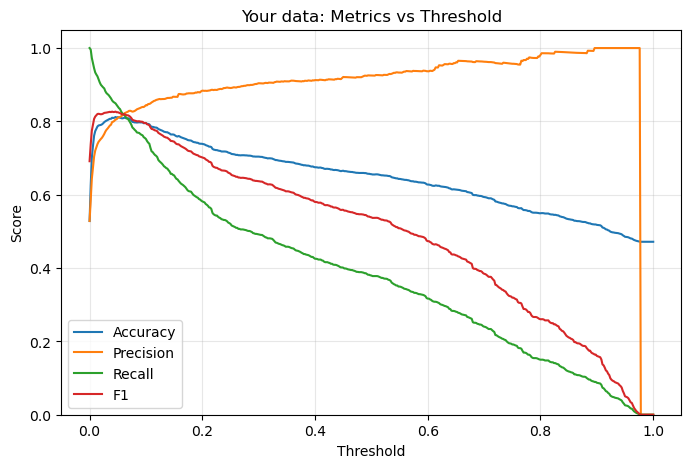

In [13]:
y_proba = best_hgb.predict_proba(X_test)[:, 1]

plot_metrics_vs_threshold(y_test, y_proba, title="Your data: Metrics vs Threshold")

In [15]:
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.0, 1.0, 101)  
rows = []
for thr in thresholds:
    y_hat = (y_proba >= thr).astype(int)
    p = precision_score(y_test, y_hat, zero_division=0)
    r = recall_score(y_test, y_hat, zero_division=0)
    f1 = f1_score(y_test, y_hat, zero_division=0)
    rows.append((thr, p, r, f1))

cand = [(thr, p, r, f1) for (thr, p, r, f1) in rows if f1 >= 0.80]
if cand:
    thr_star, p_star, r_star, f1 = max(cand, key=lambda x: x[2]) 
else:
    thr_star, p_star, r_star, f1 = 0.5, None, None, None

print(f"Chosen threshold: {thr_star:.3f}  (F1 ≥ 0.80)")
y_pred_thr = (y_proba >= thr_star).astype(int)
print("Precision/Recall/F1 @ thr:", 
      precision_score(y_test, y_pred_thr), 
      recall_score(y_test, y_pred_thr),
      f1_score(y_test, y_pred_thr))
print(confusion_matrix(y_test, y_pred_thr))

Chosen threshold: 0.010  (F1 ≥ 0.80)
Precision/Recall/F1 @ thr: 0.7203530060672918 0.9335239456754825 0.813200498132005
[[ 742  507]
 [  93 1306]]


In [16]:
from pathlib import Path
import joblib

ARTS = Path("../../saved-models/merged")
ARTS.mkdir(parents=True, exist_ok=True)

In [17]:
bundle = {
    "model": best_hgb,            
    "threshold": thr_star,              
}

joblib.dump(bundle, ARTS / "merged_hgb.pkl")
print("Saved →", ARTS / "merged_hgb.pkl")

Saved → ../../saved-models/merged/merged_hgb.pkl
